In [1]:
import torch
import torchvision.models
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt 

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

transform = transforms.Compose([
    transforms.Resize([96, 180]),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()    
])

def f(t):
    return torch.tensor([t]).float()

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnnStack = nn.Sequential(
            nn.Conv2d(1, 64, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),

            nn.Conv2d(64, 128, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),
            
            nn.Conv2d(128, 256, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),
            
            nn.Conv2d(256, 512, (5, 3), padding = (2,1)),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d((2,1)),

            nn.Flatten(),
            nn.Linear(552960, 2),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.cnnStack(x)

device = torch.device(device)
model = NeuralNetwork().to(device)

Using cpu device


torch.Size([1, 1, 96, 180])
torch.Size([1, 1])


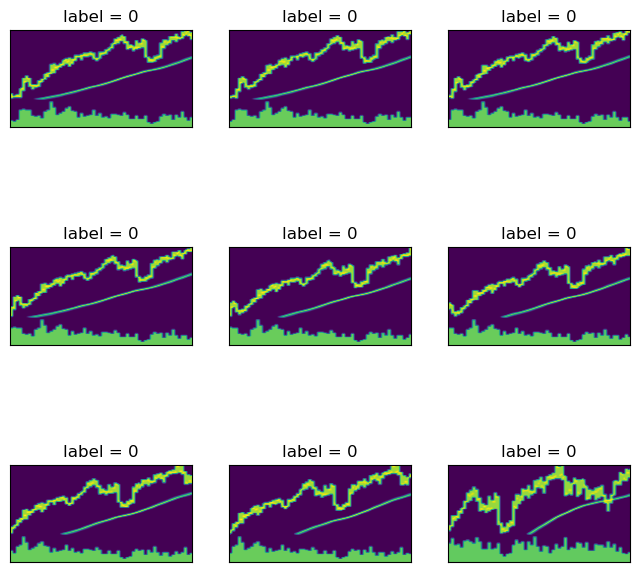

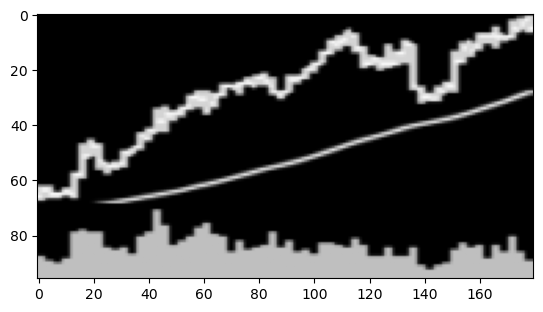

In [2]:
path = r"/kaggle/input/chinafutureohlc/test/60"
ds = datasets.ImageFolder(path, transform = transform, target_transform= f)

dl = DataLoader(ds,batch_size=1)

for features,labels in dl:
    print(features.shape)
    print(labels.shape)
    break

plt.figure(figsize=(8,8)) 
for i in range(1,10):
    img,label = ds[i]
    img = img.permute(1,2,0)
    ax=plt.subplot(3,3,i)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label.item())
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

for i, data in enumerate(dl):
    images, labels = data

    img = torchvision.utils.make_grid(images).numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()
    break

In [3]:
PATH = r"/kaggle/input/tempmodel/chkpt80.pt"
checkpoint = torch.load(PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer = torch.optim.ASGD(model.parameters(), lr = 0.092)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
def two_hot(y):
    label = []
    for i in range(len(y)):
        if y[i]==1:
            label.append([0,1])
        else:
            label.append([1,0])
    return torch.Tensor(label).to(device)

def predict(dataloader, model):
    import re
    model.eval()
    result = []   
    with torch.no_grad():
        for i, (images, labels) in enumerate(dl, 0):
            outputs = model(images)
            pred = outputs.data[0]
            sample_fname, _ = dl.dataset.samples[i]
            #print(sample_fname, pred)
            sample_fname = re.findall("\w+\.\d{4}[-|.|/]?\d{2}[-|.|/]?\d{2}\.\d\.\d+", sample_fname)[0]
            result.append(sample_fname.split(".")+pred.tolist())
    return result

In [4]:
ans = predict(dl,model)
torch.save(ans,'/kaggle/working/ans.pt')